# River Input Data Checker
**Author Jun Sasaki Coded on 2025-09-04 Updated on 2025-09-04**<br>
**Purpose:** Check and visualize FVCOM river input files without requiring simulation output

This notebook reads:
- FVCOM grid file (.grd)
- River namelist file (.nml)
- River NetCDF file (.nc)

And visualizes:
- River node locations on mesh map
- Time series of river discharge, temperature, and salinity

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.io.img_tiles import GoogleTiles

# Import xfvcom modules
from xfvcom.io.input_loader import FvcomInputLoader
from xfvcom import FvcomPlotter, FvcomPlotConfig, FvcomPlotOptions
from xfvcom import parse_river_namelist
from xfvcom import make_node_marker_post
from xfvcom.grid import FvcomGrid

# For development - optional cell skipping
from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print("This cell is skipped.")

# Create directory for output images
png_dir = Path("PNG")
png_dir.mkdir(exist_ok=True)

print("Notebook initialized successfully")

Notebook initialized successfully


## 1. Define Input File Paths
Modify these paths to point to your input files

In [2]:
# Define base directory for your FVCOM project
base_path = Path("~/Github/TB-FVCOM/goto2023").expanduser()

# Grid file (required)
grid_file = "TokyoBay18_grd.dat"  # or .dat file
grid_path = base_path / "input" / grid_file

# River input files
#river_nc_file = "TokyoBayfinal16_river.nc"
#river_nc_file = "TokyoBayfinal_sewer.nc"
# river_nc_file = "TokyoBayfinal_sewer.nc"
river_nc_file = "TokyoBay2020kisarazufinal_sewer.nc"
#river_nml_file = "RIVERS_NAMELIST16.nml"
river_nml_file = "RIVERS_NAMELIST10kisarazu_2020.nml"
#river_nml_file = "RIVERS_NAMELIST10_2020.nml"
river_nc_path = base_path / "input/2020" / river_nc_file
river_nml_path = base_path / "input/2020" / river_nml_file

# UTM zone for Tokyo Bay (required for geographic grids)
utm_zone = 54

# Check if files exist
print(f"Grid file exists: {grid_path.exists()}")
print(f"River NC exists: {river_nc_path.exists()}")
print(f"River NML exists: {river_nml_path.exists()}")

Grid file exists: True
River NC exists: True
River NML exists: True


## 2. Load Grid Data
Load the FVCOM grid file to get mesh structure and node coordinates

In [3]:
# Load grid using FvcomInputLoader
loader = FvcomInputLoader(
    grid_path=grid_path,
    utm_zone=utm_zone,
    add_dummy_time=False,  # We don't need dummy time for this
    add_dummy_siglay=False  # We don't need dummy sigma layers
)

# Get the dataset and grid object
grid_ds = loader.ds
grid_obj = loader.grid

print(f"Grid loaded successfully")
print(f"Number of nodes: {grid_obj.node}")
print(f"Number of elements: {grid_obj.nele}")
print(f"Coordinate range:")
print(f"  Longitude: {grid_ds.lon.min().values:.3f} - {grid_ds.lon.max().values:.3f}")
print(f"  Latitude: {grid_ds.lat.min().values:.3f} - {grid_ds.lat.max().values:.3f}")

Grid loaded successfully
Number of nodes: 3210
Number of elements: 5645
Coordinate range:
  Longitude: 139.629 - 140.112
  Latitude: 34.972 - 35.695


## 3. Load River Configuration
Parse the river namelist file to get river names and node locations

In [4]:
# Parse river namelist
river_df = parse_river_namelist(river_nml_path, to_zero_based=True)

print(f"Number of rivers: {len(river_df)}")
print("\nRiver configuration:")
print(river_df[['name', 'grid_location', 'file']].to_string())

Number of rivers: 30

River configuration:
                name  grid_location                                file
0        EastArakawa            309          TokyoBay2020final_river.nc
1      CenterArakawa            240          TokyoBay2020final_river.nc
2        WestArakawa            311          TokyoBay2020final_river.nc
3       SouthArakawa            447          TokyoBay2020final_river.nc
4    FirstSumidagawa              3          TokyoBay2020final_river.nc
5   SecondSumidagawa              1          TokyoBay2020final_river.nc
6    ThirdSumidagawa             11          TokyoBay2020final_river.nc
7         OneEdogawa            505          TokyoBay2020final_river.nc
8         TwoEdogawa            559          TokyoBay2020final_river.nc
9       ThreeEdogawa            615          TokyoBay2020final_river.nc
10      IchiTamagawa           1116          TokyoBay2020final_river.nc
11        NiTamagawa           1057          TokyoBay2020final_river.nc
12       SanTamagawa 

## 4. Load River NetCDF Data
Read the river forcing NetCDF file to get time series data

In [5]:
# Load river NetCDF file with decode_times=False to handle non-standard time units
river_ds = xr.open_dataset(river_nc_path, decode_times=False)

print("River NetCDF variables:")
for var in river_ds.data_vars:
    print(f"  {var}: {river_ds[var].sizes} - {river_ds[var].attrs.get('long_name', 'No description')}")

# Handle time manually for FVCOM format
if 'time' in river_ds:
    # FVCOM uses Itime (days) and Itime2 (milliseconds since midnight)
    # Convert to datetime
    if 'Itime' in river_ds and 'Itime2' in river_ds:
        # Convert modified julian day to datetime
        base_date = pd.Timestamp('1858-11-17')  # Modified Julian Day epoch
        days = river_ds.Itime.values
        milliseconds = river_ds.Itime2.values
        
        # Create datetime array
        times = []
        for day, ms in zip(days, milliseconds):
            dt = base_date + pd.Timedelta(days=int(day)) + pd.Timedelta(milliseconds=int(ms))
            times.append(dt)
        
        # Replace time coordinate with proper datetime
        river_ds = river_ds.assign_coords(time=pd.DatetimeIndex(times))
    elif 'time' in river_ds.coords:
        # Try to parse time values if they exist
        try:
            # Attempt to convert time values
            time_units = river_ds.time.attrs.get('units', '')
            if 'days since' in time_units:
                # Parse reference date from units
                ref_date_str = time_units.split('days since')[1].strip()
                ref_date = pd.Timestamp(ref_date_str)
                times = [ref_date + pd.Timedelta(days=float(t)) for t in river_ds.time.values]
                river_ds = river_ds.assign_coords(time=pd.DatetimeIndex(times))
        except:
            print("Warning: Could not decode time values")
    
    # Get time range
    if isinstance(river_ds.time.values[0], (pd.Timestamp, np.datetime64)):
        time_start = pd.Timestamp(river_ds.time.values[0])
        time_end = pd.Timestamp(river_ds.time.values[-1])
        print(f"\nTime range: {time_start} to {time_end}")
        print(f"Number of time steps: {len(river_ds.time)}")
    else:
        print(f"\nNumber of time steps: {len(river_ds.time)}")

# Check if number of rivers matches
n_rivers_nc = river_ds.sizes.get('river', river_ds.sizes.get('rivers', 0))
print(f"\nNumber of rivers in NetCDF: {n_rivers_nc}")
if n_rivers_nc != len(river_df):
    print(f"WARNING: Number mismatch with namelist ({len(river_df)} rivers)")

River NetCDF variables:
  river_names: Frozen({'rivers': 8}) - No description
  Itime: Frozen({'time': 8784}) - No description
  Itime2: Frozen({'time': 8784}) - No description
  Times: Frozen({'time': 8784}) - No description
  river_flux: Frozen({'time': 8784, 'rivers': 8}) - river runoff volume flux
  river_temp: Frozen({'time': 8784, 'rivers': 8}) - river runoff temperature
  river_salt: Frozen({'time': 8784, 'rivers': 8}) - river runoff salinity

Time range: 2020-01-01 00:00:00 to 2020-12-31 23:00:00
Number of time steps: 8784

Number of rivers in NetCDF: 8


## 5. Plot River Nodes on Mesh Map
Visualize where the rivers are located on the mesh

River nodes map saved to PNG/river_nodes_map.png


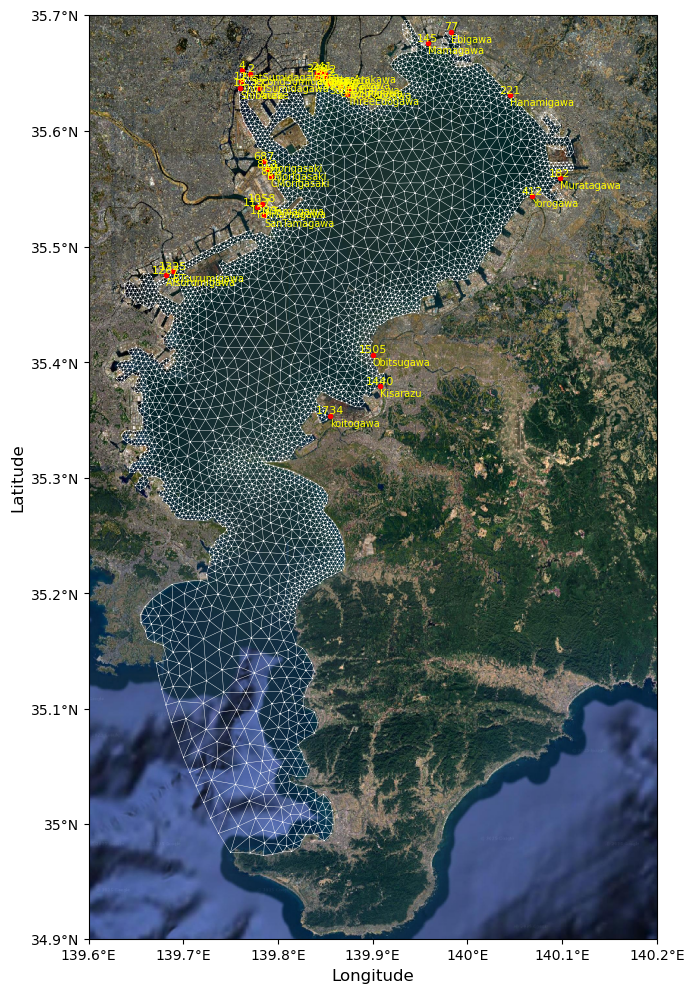

In [6]:
# Create plotter for visualization
cfg = FvcomPlotConfig()
plotter = FvcomPlotter(grid_ds, cfg)

# Option to show river names (set to False to show only numbers)
show_river_names = True

# Set map domain
xlim=(float(grid_ds.lon.min()), float(grid_ds.lon.max()))
ylim=(float(grid_ds.lat.min()), float(grid_ds.lat.max()))

# Define marker and text styling
mkw = {"marker": "o", "color": "red", "markersize": 3, "zorder": 4}
tkw = {"fontsize": 8, "color": "yellow", "ha": "center", "va": "bottom",
       "zorder": 5, "clip_on": True}

# Convert 0-based indices to 1-based for make_node_marker_post
# (river_df.grid_location is already 0-based from parse_river_namelist)
river_nodes_1based = river_df.grid_location + 1

# Create post-processing function using make_node_marker_post
pp = make_node_marker_post(
    river_nodes_1based,  # Pass 1-based indices
    plotter,
    marker_kwargs=mkw,
    text_kwargs=tkw,
    index_base=1,
)

# Add river names if enabled
if show_river_names:
    # Create a wrapper function that calls both the marker function and adds names
    def pp_with_names(ax):
        # First call the original post-processing function
        pp(ax)
        
        # Then add river names next to the numbers
        for idx, row in river_df.iterrows():
            node_idx = row['grid_location']  # 0-based index
            lon = plotter.ds.lon.values[node_idx]
            lat = plotter.ds.lat.values[node_idx]
            
            # Add river name text (slightly offset from the number)
            ax.text(lon, lat - 0.002, f"{row['name']}", 
                    fontsize=7, color='yellow', 
                    transform=ccrs.PlateCarree(), 
                    ha='left', va='top', zorder=5,
                    bbox=dict(boxstyle='round,pad=0.2', facecolor='black', alpha=0))
    
    post_process_func = pp_with_names
else:
    post_process_func = pp

# Plot options
opts = FvcomPlotOptions(
    figsize=(10, 12),
    add_tiles=True,
    tile_provider=GoogleTiles(style="satellite"),
    mesh_color="#ffffff",
    mesh_linewidth=0.3,
    title="River Input Nodes on FVCOM Mesh",
    # Adjust these bounds for your domain
    xlim=xlim,
    ylim=ylim,
)

# Create the plot
ax = plotter.plot_2d(da=None, post_process_func=post_process_func, opts=opts)

# Save figure
ax.figure.savefig(png_dir / "river_nodes_map.png", dpi=300, bbox_inches='tight')
print("River nodes map saved to PNG/river_nodes_map.png")

## 6. Plot River Time Series
Visualize discharge, temperature, and salinity for each river

Rivers in NetCDF file: ['Shibaura', 'Sunamachi', 'Ariake', 'Kasai', 'Kisarazu', 'AMorigasaki', 'BMorigasaki', 'CMorigasaki']


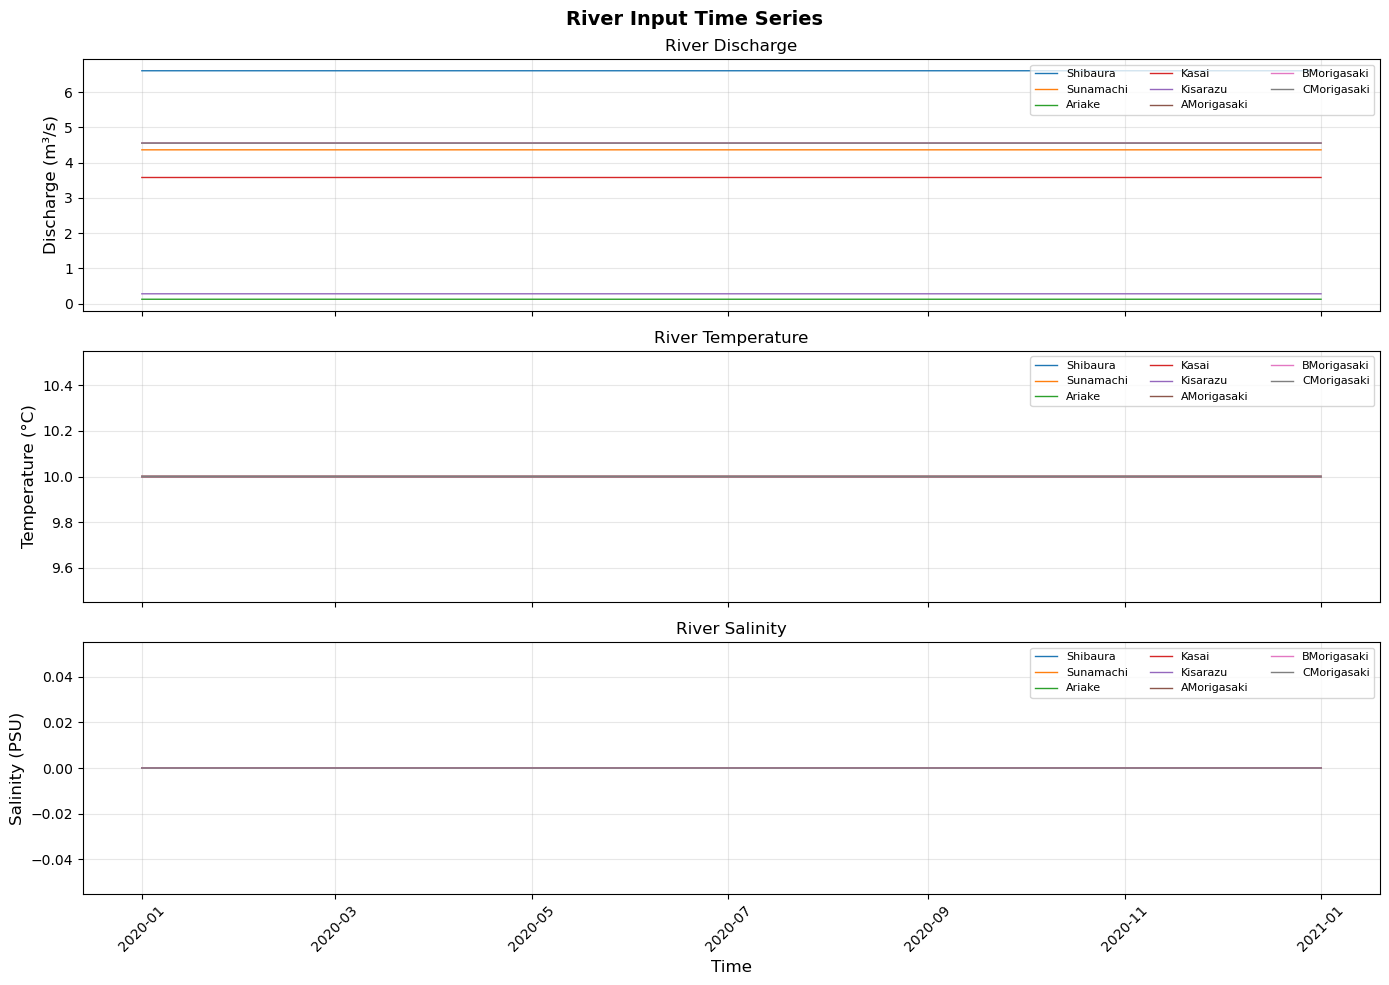

River time series saved to PNG/river_timeseries.png


In [7]:
# Identify the dimension name for rivers
river_dim = 'river' if 'river' in river_ds.sizes else 'rivers'

# Create figure with subplots for time series
fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=True)
fig.suptitle('River Input Time Series', fontsize=14, fontweight='bold')

# Convert time to pandas datetime for better plotting
time_pd = pd.to_datetime(river_ds.time.values)

# Get river names from the NetCDF file if available
if 'river_names' in river_ds:
    # Decode river names from NetCDF
    river_names_nc = []
    for i in range(n_rivers_nc):
        name_chars = river_ds.river_names.isel({river_dim: i}).values
        if isinstance(name_chars, bytes):
            # If it's already bytes, decode directly
            name = name_chars.decode('utf-8').strip()
        elif hasattr(name_chars, 'dtype') and name_chars.dtype.kind == 'S':
            # If it's a byte string array
            name = name_chars.tobytes().decode('utf-8').strip()
        elif hasattr(name_chars, '__iter__') and not isinstance(name_chars, str):
            # If it's an array of characters
            try:
                # Join characters and decode
                name = b''.join(name_chars).decode('utf-8').strip()
            except:
                # If that fails, try converting each element
                name = ''.join([chr(c) if isinstance(c, (int, np.integer)) else str(c) 
                               for c in name_chars.flatten()]).strip().rstrip('\x00')
        else:
            # Fallback: convert to string
            name = str(name_chars).strip()
        river_names_nc.append(name)
else:
    # Fall back to generic names if river_names not in NetCDF
    river_names_nc = [f"River {i+1}" for i in range(n_rivers_nc)]

print(f"Rivers in NetCDF file: {river_names_nc}")

# Plot 1: River discharge
ax = axes[0]
if 'river_flux' in river_ds:
    for i in range(n_rivers_nc):
        river_name = river_names_nc[i]
        flux = river_ds.river_flux.isel({river_dim: i}).values
        ax.plot(time_pd, flux, label=river_name, linewidth=1)
    ax.set_ylabel('Discharge (m³/s)', fontsize=12)
    ax.set_title('River Discharge', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=3, loc='upper right', fontsize=8)

# Plot 2: River temperature
ax = axes[1]
if 'river_temp' in river_ds:
    for i in range(n_rivers_nc):
        river_name = river_names_nc[i]
        temp = river_ds.river_temp.isel({river_dim: i}).values
        ax.plot(time_pd, temp, label=river_name, linewidth=1)
    ax.set_ylabel('Temperature (°C)', fontsize=12)
    ax.set_title('River Temperature', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=3, loc='upper right', fontsize=8)

# Plot 3: River salinity
ax = axes[2]
if 'river_salt' in river_ds:
    for i in range(n_rivers_nc):
        river_name = river_names_nc[i]
        salt = river_ds.river_salt.isel({river_dim: i}).values
        ax.plot(time_pd, salt, label=river_name, linewidth=1)
    ax.set_ylabel('Salinity (PSU)', fontsize=12)
    ax.set_title('River Salinity', fontsize=12)
    ax.grid(True, alpha=0.3)
    ax.legend(ncol=3, loc='upper right', fontsize=8)

# Format x-axis
axes[-1].set_xlabel('Time', fontsize=12)
axes[-1].tick_params(axis='x', rotation=45)

# Adjust layout and save
plt.tight_layout()
fig.savefig(png_dir / "river_timeseries.png", dpi=300, bbox_inches='tight')
plt.show()
print("River time series saved to PNG/river_timeseries.png")

## 7. Individual River Analysis
Select and analyze individual rivers in detail

Analyzing River from NetCDF: Shibaura
Matched with NML entry: Shibaura
Node location (0-based): 17
Input file: TokyoBay2020kisarazufinal_sewer.nc
Coordinates: (139.7602°E, 35.6371°N)

Discharge Statistics:
  Mean: 6.61 m³/s
  Min: 6.61 m³/s
  Max: 6.61 m³/s
  Std: 0.00 m³/s

Temperature Statistics:
  Mean: 10.00 °C
  Min: 10.00 °C
  Max: 10.00 °C

Salinity Statistics:
  Mean: 0.000 PSU
  Min: 0.000 PSU
  Max: 0.000 PSU


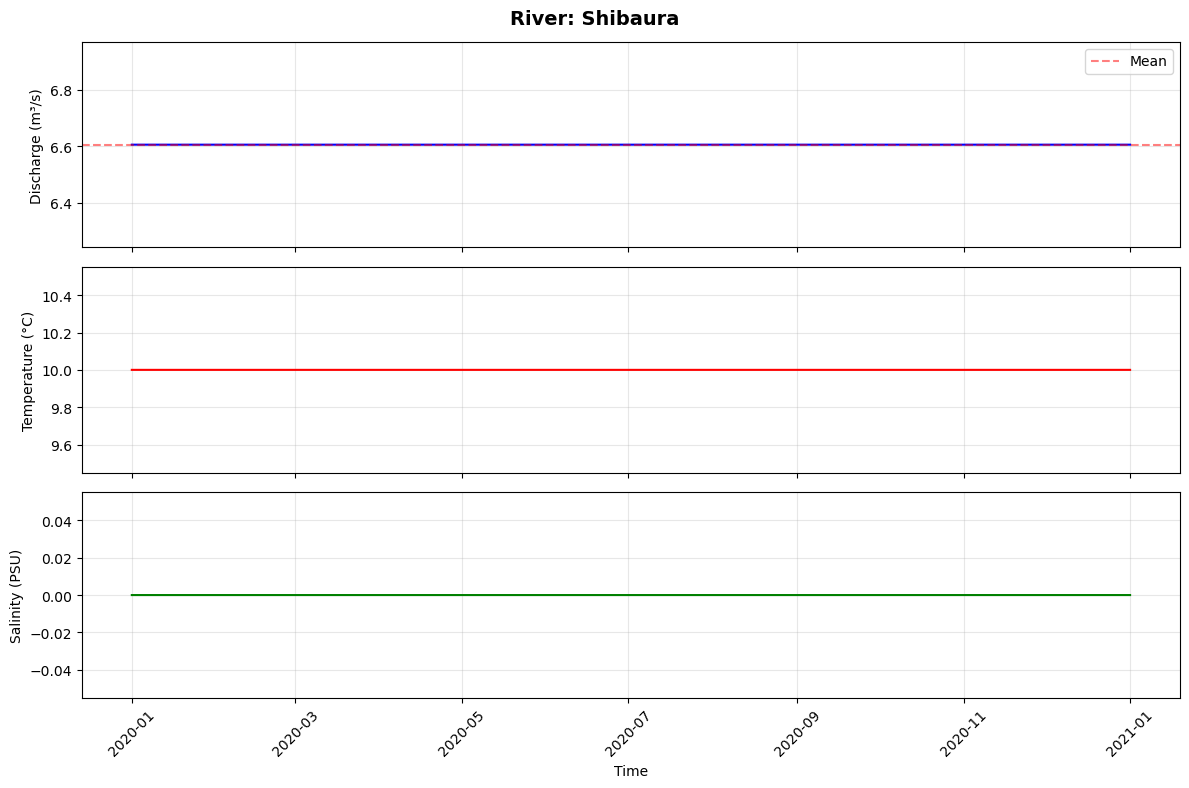


Detailed plot saved to PNG/river_0_Shibaura.png


In [8]:
# Select a river to analyze (change this index as needed)
river_index = 0  # First river (0-based index)

# Get river names from the NetCDF file if available
if 'river_names' in river_ds:
    # Decode river names from NetCDF
    river_names_nc = []
    for i in range(n_rivers_nc):
        name_chars = river_ds.river_names.isel({river_dim: i}).values
        if isinstance(name_chars, bytes):
            # If it's already bytes, decode directly
            name = name_chars.decode('utf-8').strip()
        elif hasattr(name_chars, 'dtype') and name_chars.dtype.kind == 'S':
            # If it's a byte string array
            name = name_chars.tobytes().decode('utf-8').strip()
        elif hasattr(name_chars, '__iter__') and not isinstance(name_chars, str):
            # If it's an array of characters
            try:
                # Join characters and decode
                name = b''.join(name_chars).decode('utf-8').strip()
            except:
                # If that fails, try converting each element
                name = ''.join([chr(c) if isinstance(c, (int, np.integer)) else str(c) 
                               for c in name_chars.flatten()]).strip().rstrip('\x00')
        else:
            # Fallback: convert to string
            name = str(name_chars).strip()
        river_names_nc.append(name)
else:
    river_names_nc = [f"River {i+1}" for i in range(n_rivers_nc)]

if river_index < n_rivers_nc:
    river_name_nc = river_names_nc[river_index]
    print(f"Analyzing River from NetCDF: {river_name_nc}")
    
    # Try to find matching river in NML file
    matching_rivers = river_df[river_df['name'].str.contains(river_name_nc, case=False, na=False)]
    if not matching_rivers.empty:
        river_info = matching_rivers.iloc[0]
        print(f"Matched with NML entry: {river_info['name']}")
        print(f"Node location (0-based): {river_info['grid_location']}")
        print(f"Input file: {river_info['file']}")
        
        # Get node coordinates
        node_idx = river_info['grid_location']
        lon = grid_ds.lon.values[node_idx]
        lat = grid_ds.lat.values[node_idx]
        print(f"Coordinates: ({lon:.4f}°E, {lat:.4f}°N)")
    else:
        print(f"No matching river found in NML file for '{river_name_nc}'")
    
    # Get time series data from NetCDF
    flux = river_ds.river_flux.isel({river_dim: river_index})
    temp = river_ds.river_temp.isel({river_dim: river_index}) if 'river_temp' in river_ds else None
    salt = river_ds.river_salt.isel({river_dim: river_index}) if 'river_salt' in river_ds else None
    
    # Statistics
    print(f"\nDischarge Statistics:")
    print(f"  Mean: {flux.mean().values:.2f} m³/s")
    print(f"  Min: {flux.min().values:.2f} m³/s")
    print(f"  Max: {flux.max().values:.2f} m³/s")
    print(f"  Std: {flux.std().values:.2f} m³/s")
    
    if temp is not None:
        print(f"\nTemperature Statistics:")
        print(f"  Mean: {temp.mean().values:.2f} °C")
        print(f"  Min: {temp.min().values:.2f} °C")
        print(f"  Max: {temp.max().values:.2f} °C")
    
    if salt is not None:
        print(f"\nSalinity Statistics:")
        print(f"  Mean: {salt.mean().values:.3f} PSU")
        print(f"  Min: {salt.min().values:.3f} PSU")
        print(f"  Max: {salt.max().values:.3f} PSU")
    
    # Create detailed plot for this river
    fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)
    fig.suptitle(f"River: {river_name_nc}", fontsize=14, fontweight='bold')
    
    time_pd = pd.to_datetime(river_ds.time.values)
    
    # Discharge
    axes[0].plot(time_pd, flux.values, 'b-', linewidth=1.5)
    axes[0].set_ylabel('Discharge (m³/s)')
    axes[0].grid(True, alpha=0.3)
    axes[0].axhline(y=flux.mean().values, color='r', linestyle='--', alpha=0.5, label='Mean')
    axes[0].legend()
    
    # Temperature
    if temp is not None:
        axes[1].plot(time_pd, temp.values, 'r-', linewidth=1.5)
        axes[1].set_ylabel('Temperature (°C)')
        axes[1].grid(True, alpha=0.3)
    
    # Salinity
    if salt is not None:
        axes[2].plot(time_pd, salt.values, 'g-', linewidth=1.5)
        axes[2].set_ylabel('Salinity (PSU)')
        axes[2].grid(True, alpha=0.3)
    
    axes[-1].set_xlabel('Time')
    axes[-1].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    safe_name = river_name_nc.replace(' ', '_').replace('/', '_')
    fig.savefig(png_dir / f"river_{river_index}_{safe_name}.png", 
               dpi=300, bbox_inches='tight')
    plt.show()
    print(f"\nDetailed plot saved to PNG/river_{river_index}_{safe_name}.png")
else:
    print(f"River index {river_index} is out of range (0-{n_rivers_nc-1})")

## 8. Summary and Export
Create a summary report of all river inputs

In [9]:
# Get river names from the NetCDF file if available
if 'river_names' in river_ds:
    # Decode river names from NetCDF
    river_names_nc = []
    for i in range(n_rivers_nc):
        name_chars = river_ds.river_names.isel({river_dim: i}).values
        if isinstance(name_chars, bytes):
            # If it's already bytes, decode directly
            name = name_chars.decode('utf-8').strip()
        elif hasattr(name_chars, 'dtype') and name_chars.dtype.kind == 'S':
            # If it's a byte string array
            name = name_chars.tobytes().decode('utf-8').strip()
        elif hasattr(name_chars, '__iter__') and not isinstance(name_chars, str):
            # If it's an array of characters
            try:
                # Join characters and decode
                name = b''.join(name_chars).decode('utf-8').strip()
            except:
                # If that fails, try converting each element
                name = ''.join([chr(c) if isinstance(c, (int, np.integer)) else str(c) 
                               for c in name_chars.flatten()]).strip().rstrip('\x00')
        else:
            # Fallback: convert to string
            name = str(name_chars).strip()
        river_names_nc.append(name)
else:
    river_names_nc = [f"River {i+1}" for i in range(n_rivers_nc)]

# Create summary DataFrame
summary_data = []

for i in range(n_rivers_nc):
    river_name_nc = river_names_nc[i]
    
    # Try to find matching river in NML file for location info
    matching_rivers = river_df[river_df['name'].str.contains(river_name_nc, case=False, na=False)]
    
    if not matching_rivers.empty:
        river_info = matching_rivers.iloc[0]
        node_idx = river_info['grid_location']
        lon = grid_ds.lon.values[node_idx]
        lat = grid_ds.lat.values[node_idx]
    else:
        # No match found, use NaN for coordinates
        node_idx = -1
        lon = np.nan
        lat = np.nan
    
    # Get statistics from NetCDF
    flux = river_ds.river_flux.isel({river_dim: i})
    temp = river_ds.river_temp.isel({river_dim: i}) if 'river_temp' in river_ds else None
    salt = river_ds.river_salt.isel({river_dim: i}) if 'river_salt' in river_ds else None
    
    summary_data.append({
        'River Name (NetCDF)': river_name_nc,
        'Node Index': node_idx if node_idx >= 0 else 'Not found',
        'Longitude': lon,
        'Latitude': lat,
        'Mean Discharge (m³/s)': flux.mean().values,
        'Max Discharge (m³/s)': flux.max().values,
        'Mean Temp (°C)': temp.mean().values if temp is not None else np.nan,
        'Mean Salinity (PSU)': salt.mean().values if salt is not None else np.nan,
    })

summary_df = pd.DataFrame(summary_data)

# Display summary
print("River Input Summary (from NetCDF file):")
print("="*80)
print(summary_df.to_string())

# Export to CSV
csv_path = png_dir / "river_summary.csv"
summary_df.to_csv(csv_path, index=False)
print(f"\nSummary exported to {csv_path}")

# Calculate totals
total_discharge = summary_df['Mean Discharge (m³/s)'].sum()
print(f"\nTotal mean discharge from all rivers: {total_discharge:.2f} m³/s")

# Show warning about mismatch
print(f"\nNote: NetCDF file contains {n_rivers_nc} rivers")
print(f"      NML file references {len(river_df)} rivers")
if n_rivers_nc != len(river_df):
    print("WARNING: Number mismatch between NetCDF and NML files!")

River Input Summary (from NetCDF file):
  River Name (NetCDF)  Node Index   Longitude   Latitude Mean Discharge (m³/s) Max Discharge (m³/s) Mean Temp (°C) Mean Salinity (PSU)
0            Shibaura          17  139.760232  35.637098               6.60581             6.605809           10.0                 0.0
1           Sunamachi         239  139.840939  35.649942             4.3637996             4.363799           10.0                 0.0
2              Ariake          16  139.779410  35.636969            0.12731482           0.12731482           10.0                 0.0
3               Kasai         241  139.850022  35.649114              3.579376            3.5793757           10.0                 0.0
4            Kisarazu        1439  139.907616  35.379273              0.281956           0.28195602           10.0                 0.0
5         AMorigasaki         686  139.784720  35.573620              4.554211            4.5542116           10.0                 0.0
6         BMori

## Notes

This notebook provides a comprehensive tool for checking FVCOM river input files without requiring simulation output. 

### Key Features:
1. **Direct Input File Reading**: Reads grid, river namelist, and river NetCDF files directly
2. **Spatial Visualization**: Shows river node locations on the mesh
3. **Time Series Analysis**: Plots discharge, temperature, and salinity for all rivers
4. **Individual River Analysis**: Detailed analysis of selected rivers
5. **Summary Export**: Creates CSV summary of all river inputs

### Customization:
- Modify file paths in Section 1 to point to your input files
- Adjust plot bounds and styling in Section 5
- Change the river index in Section 7 to analyze different rivers
- Add additional analysis as needed

### Requirements:
- xfvcom package with FvcomInputLoader support
- Grid file in .grd or .dat format
- River namelist file (.nml)
- River NetCDF file with standard FVCOM river variables